In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = x_train[..., tf.newaxis]
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*128, input_shape=(100,)),
        layers.ReLU(),
        layers.Reshape((7, 7, 128)),

        layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
        layers.ReLU(),

        layers.Conv2DTranspose(1, 4, strides=2, padding='same', activation='tanh')
    ])
    return model

generator = build_generator()

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-4)

Epoch 1/30 - G Loss: 1.1408, D Loss: 1.0515


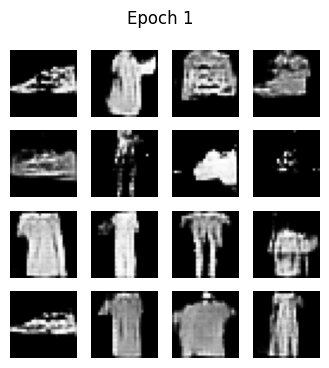

Epoch 2/30 - G Loss: 1.2179, D Loss: 1.0539


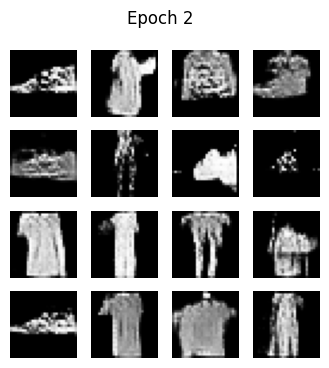

Epoch 3/30 - G Loss: 1.2480, D Loss: 1.0433


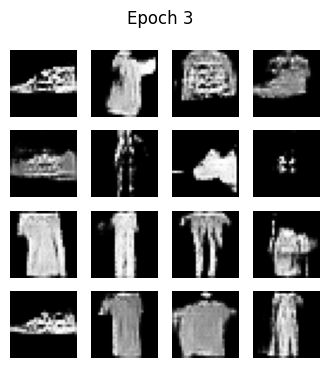

Epoch 4/30 - G Loss: 1.0255, D Loss: 1.2395


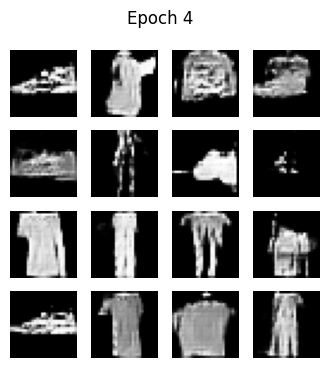

Epoch 5/30 - G Loss: 1.2145, D Loss: 1.0052


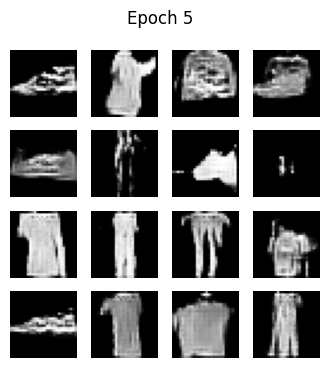

Epoch 6/30 - G Loss: 1.4858, D Loss: 0.9574


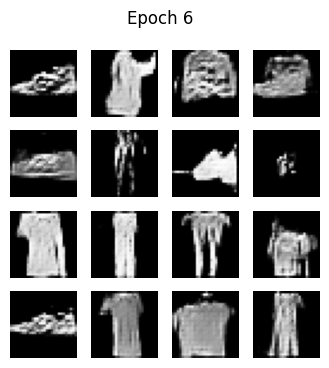

Epoch 7/30 - G Loss: 1.0433, D Loss: 1.0750


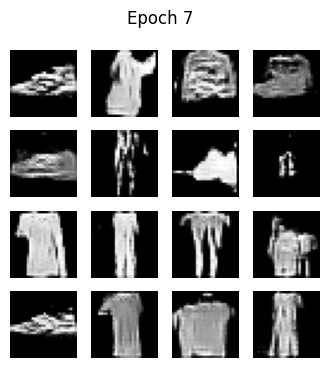

Epoch 8/30 - G Loss: 1.0194, D Loss: 1.1429


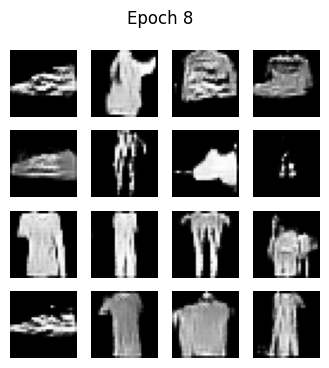

Epoch 9/30 - G Loss: 1.0583, D Loss: 1.2426


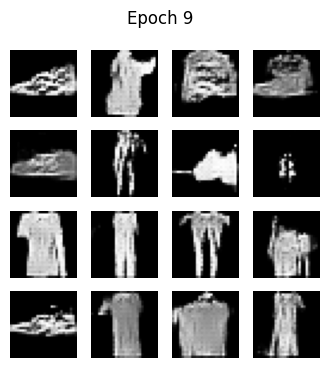

Epoch 10/30 - G Loss: 1.2014, D Loss: 1.0427


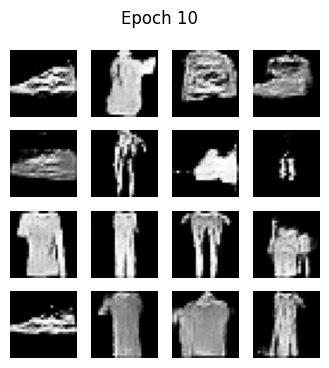

Epoch 11/30 - G Loss: 1.0668, D Loss: 1.2409


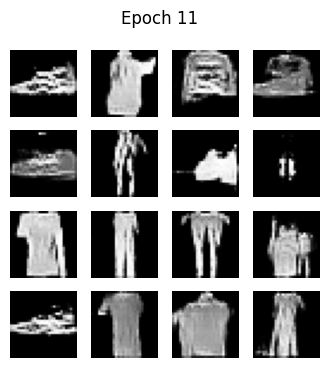

Epoch 12/30 - G Loss: 1.2247, D Loss: 1.0839


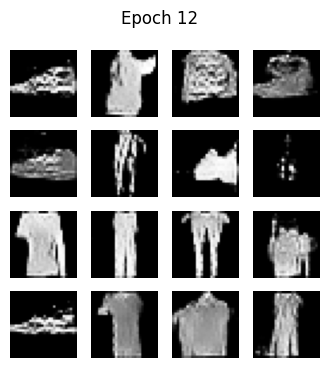

Epoch 13/30 - G Loss: 1.0333, D Loss: 1.1291


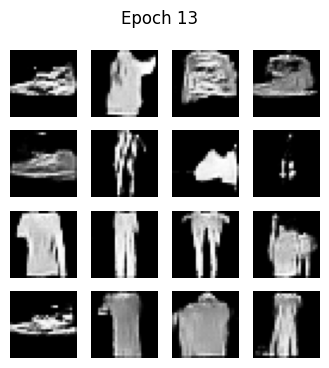

Epoch 14/30 - G Loss: 1.2386, D Loss: 1.0003


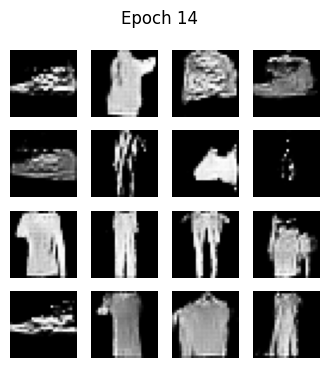

Epoch 15/30 - G Loss: 0.9896, D Loss: 1.1444


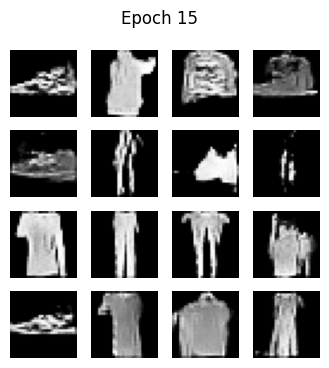

Epoch 16/30 - G Loss: 1.0707, D Loss: 1.1918


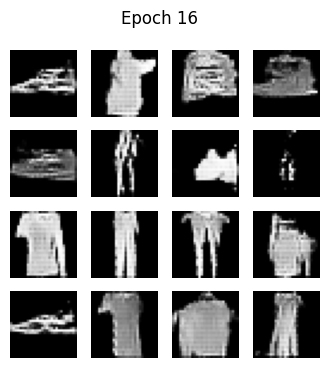

Epoch 17/30 - G Loss: 1.0589, D Loss: 1.1248


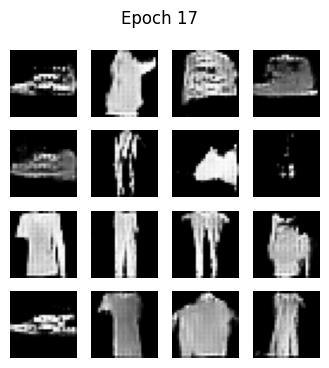

Epoch 18/30 - G Loss: 0.9673, D Loss: 1.1593


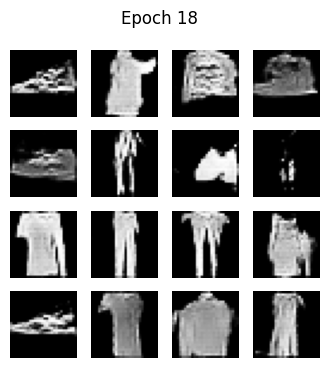

Epoch 19/30 - G Loss: 0.9947, D Loss: 1.2199


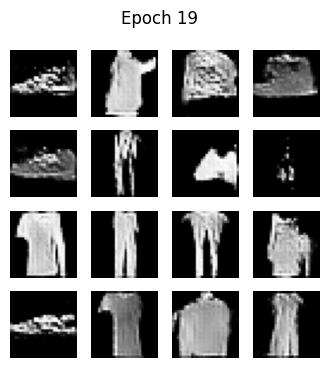

Epoch 20/30 - G Loss: 0.8329, D Loss: 1.2983


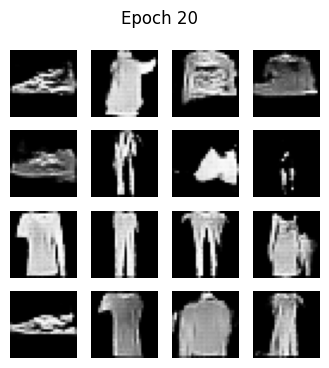

Epoch 21/30 - G Loss: 1.0081, D Loss: 1.2036


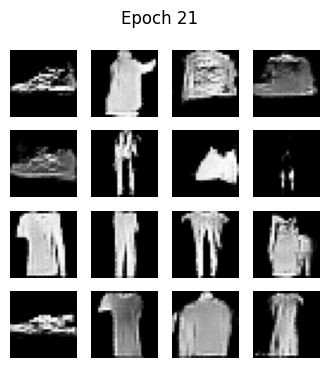

Epoch 22/30 - G Loss: 0.9911, D Loss: 1.2219


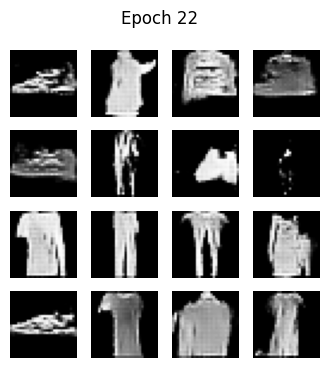

Epoch 23/30 - G Loss: 1.0131, D Loss: 1.1210


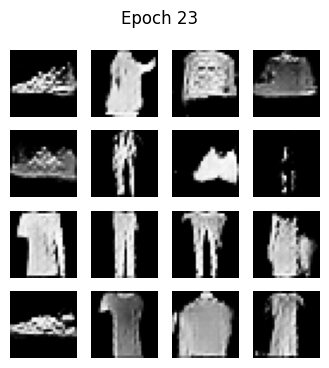

Epoch 24/30 - G Loss: 0.9097, D Loss: 1.2786


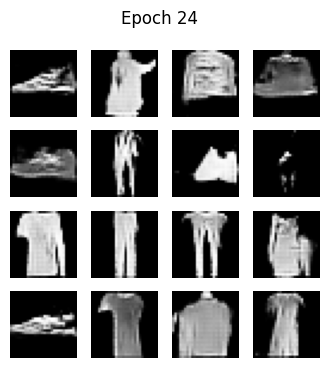

Epoch 25/30 - G Loss: 1.1976, D Loss: 1.0482


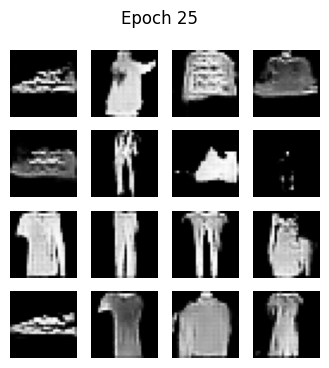

Epoch 26/30 - G Loss: 0.9422, D Loss: 1.3073


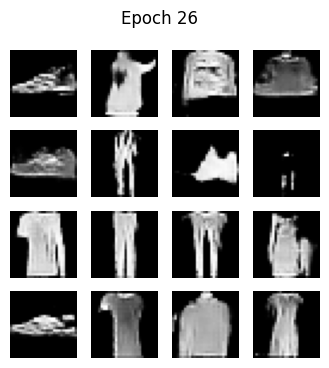

Epoch 27/30 - G Loss: 0.8916, D Loss: 1.2343


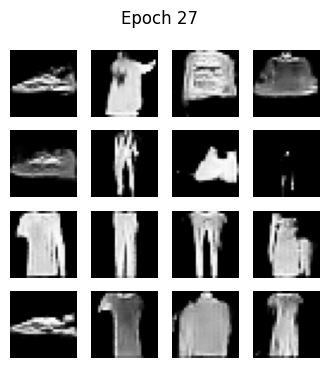

Epoch 28/30 - G Loss: 0.9381, D Loss: 1.2726


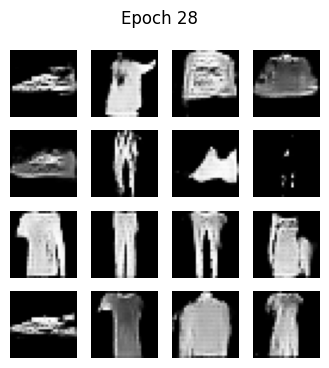

Epoch 29/30 - G Loss: 0.8520, D Loss: 1.3093


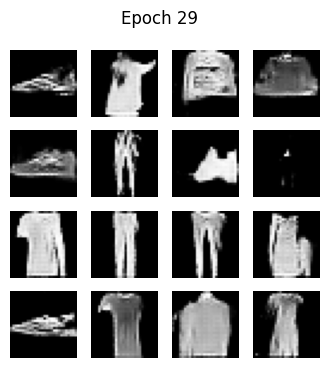

Epoch 30/30 - G Loss: 0.9260, D Loss: 1.1926


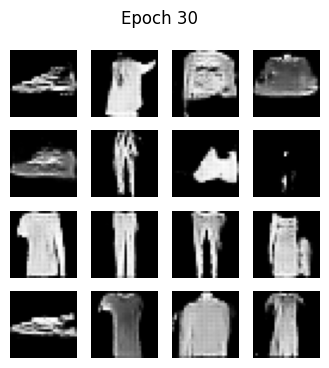

In [9]:
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        d_loss = loss_fn(tf.ones_like(real_output), real_output) + \
                 loss_fn(tf.zeros_like(fake_output), fake_output)

        g_loss = loss_fn(tf.ones_like(fake_output), fake_output)

    grads_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    grads_g = gen_tape.gradient(g_loss, generator.trainable_variables)

    d_opt.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    g_opt.apply_gradients(zip(grads_g, generator.trainable_variables))

    return g_loss, d_loss

fixed_noise = tf.random.normal([16, 100])

def train(epochs):
    for epoch in range(1, epochs+1):
        for batch in dataset:
            g_loss, d_loss = train_step(batch)

        print(f"Epoch {epoch}/{epochs} - G Loss: {g_loss:.4f}, D Loss: {d_loss:.4f}")
        generate_images(epoch, fixed_noise)

def generate_images(epoch, noise):
    preds = generator(noise, training=False)
    preds = (preds + 1) / 2.0

    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(preds[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

train(epochs=30)

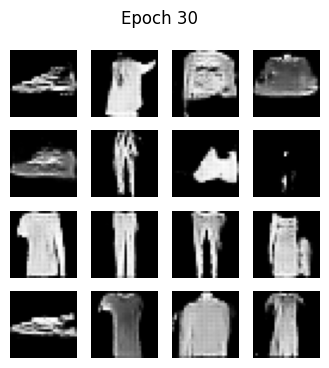

In [10]:
generate_images(30, fixed_noise)